In [2]:
import pandas as pd
import plotly.express as px
import numpy as np

import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aftershock\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aftershock\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aftershock\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Aftershock\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
file_path = '../dataset/fake_job_postings.csv'
df = pd.read_csv(file_path)

df_info = df.info()
df_head = df.head()

print(df_info)
print(df_head)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

# Data Cleaning

### Handling Duplciated Rows

No duplicated rows were found.

In [4]:
duplicates = df.duplicated()
num_duplicates = duplicates.sum()

print(f"Number of duplicated rows: {num_duplicates}")

Number of duplicated rows: 0


### Handling Missing Values

Upon inspecting the dataset, we found several fields with null values. Since these fields are all categorical, we decided to fill the missing values with the appropriate categorical values:

- Missing values filled with **"Unknown"**: Used for columns like `location` and `employment_type`, where missing data likely means the information is unavailable or not applicable. This preserves the understanding that the data may exist but is not provided.
  
- Missing values filled with **"Not Provided"**: Applied to columns such as `salary_range` and `company_profile`, where the missing information might indicate that it was purposely left out by the job poster.

In [5]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [6]:
df['location'].fillna('Unknown', inplace=True)
df['employment_type'].fillna('Unknown', inplace=True)
df['required_experience'].fillna('Unknown', inplace=True)
df['required_education'].fillna('Unknown', inplace=True)
df['industry'].fillna('Unknown', inplace=True)
df['function'].fillna('Unknown', inplace=True)

df['department'].fillna('Not Provided', inplace=True)
df['salary_range'].fillna('Not Provided', inplace=True)
df['company_profile'].fillna('Not Provided', inplace=True)
df['description'].fillna('Not Provided', inplace=True)
df['requirements'].fillna('Not Provided', inplace=True)
df['benefits'].fillna('Not Provided', inplace=True)

df_null_removed = df.copy()

missing_values = df_null_removed.isnull().sum()

missing_values

C:\Users\Aftershock\AppData\Local\Temp\ipykernel_6192\4183167162.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['location'].fillna('Unknown', inplace=True)
C:\Users\Aftershock\AppData\Local\Temp\ipykernel_6192\4183167162.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

### Feature engineering

In [7]:
columns_to_check = ['employment_type', 'required_experience', 'required_education', 'industry', 
                    'function', 'department', 'salary_range']

value_counts_dict = {col: df[col].value_counts() for col in columns_to_check}

for key, value in value_counts_dict.items():
    print(f"Column: {key}")
    print(value)
    print("-" * 50)

Column: employment_type
employment_type
Full-time    11620
Unknown       3471
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: count, dtype: int64
--------------------------------------------------
Column: required_experience
required_experience
Unknown             7050
Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: count, dtype: int64
--------------------------------------------------
Column: required_education
required_education
Unknown                              8105
Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational          

All categorical columns have a good split for each individual category except salary_range. We can improve the salary_range column by splitting by a delimiter and engineer 2 additional columns.

In [8]:
# Function to extract the number of digits in a salary value
def extract_salary_digits(salary_str):
    if pd.isnull(salary_str) or salary_str == 'Not Provided':
        return 0, 0  # For missing values, return 0 for both min and max salary digits
    try:
        # Split the salary range
        min_salary, max_salary = salary_str.split('-')
        min_digits = len(min_salary.strip())
        max_digits = len(max_salary.strip())
        return min_digits, max_digits
    except ValueError:
        return 0, 0  # In case the salary string is not in the expected format

# Apply the function to split min and max salary digits
df_null_removed['min_salary_digits'], df_null_removed['max_salary_digits'] = zip(*df_null_removed['salary_range'].apply(extract_salary_digits))

# Create binary column to indicate whether salary range was provided
df_null_removed['salary_range_provided'] = np.where(df_null_removed['salary_range'] == 'Not Provided', 0, 1)
df_null_removed.drop(columns=['salary_range'], inplace=True)

###  Additional features

In [9]:
pd.set_option('display.max_rows', None)

In [10]:
print(df_null_removed[df_null_removed['fraudulent'] == 1]['description'])

98       IC&amp;E Technician | Bakersfield, CA Mt. Poso...
144      The group has raised a fund for the purchase o...
173      Technician Instrument &amp; ControlsLocation D...
180                                        Sales Executive
215      IC&amp;E Technician | Bakersfield, CA Mt. Poso...
357      If you have experience in financing for auto s...
493      A Newly established company seeks outgoing, fr...
537      Apply below using link#URL_00962c0bdac3ecf40b2...
573      Senior Engineering Product ManagerAs a member ...
584      Apply using below link#URL_8b28dea5804b323e29d...
603      Corporate overviewAker Solutions is a global p...
606      Director of Strategy | San Mateo, CA Intereste...
628      Qualified candidates are encouraged to apply d...
661      Director of Strategy | San Mateo, CA Intereste...
740      Health &amp; Safety Professional | Bakersfield...
812         UST Testing Technician II Bakersfield, CA L...
814      We are a full-service engineering, project man.

In [11]:
# Length of the job description
df_null_removed['description_length'] = df_null_removed['description'].apply(lambda x: 0 if x == 'Not Provided' else len(x))

# Whether the description contains external links
def contains_external_link(text):
    if pd.isnull(text):
        return 0
    return 1 if re.search(r'http[s]?://', text) else 0

df_null_removed['has_external_link'] = df_null_removed['description'].apply(contains_external_link)

# Whether job description contains common scam phrases as per research
# Source: https://bgc-group.com/common-job-scams-in-singapore-and-how-to-avoid-them/#:~:text=If%20it's%20too%20good%20to%20be%20true%2C%20it's%20not%20true&text=Job%20scammers%20often%20try%20to,away%20before%20it's%20too%20late.

scam_phrases = ["quick cash", "flexible hours", "work from home", "no experience needed", 
                "too good to be true", "application fee", "deposit", "earn", "no experience", 
                "no exp" "fast cash", "easy cash"]

df_null_removed['contains_scam_phrases'] = df_null_removed['description'].apply(
    lambda x: any(phrase in x.lower() for phrase in scam_phrases)
)

### Investigating and Handling Outliers

After handling missing values, we checked for potential outliers in the dataset. For this, we only focused on the numeric columns. Using the **Interquartile Range (IQR)** method, outliers were found in columns such as `telecommuting`, `has_company_logo`, and `fraudulent`. 

Upon further investigation, we plotted these columns and found that the "outliers" were a result of **class imbalance** rather than true outliers. Since these columns are binary and categorical in nature, the detected values were not problematic for analysis and thus no additional outlier removal was needed.

This step helped us realise that there is data imbalance in certain categories.

In [12]:
numeric_columns = df_null_removed.select_dtypes(include=['int64', 'float64']).columns

def detect_outliers_iqr_with_print(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Defining outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identifying outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    # Print IQR and boundaries
    print(f"Column: {column}")
    print(f"Q1: {Q1}, Q3: {Q3}")
    print(f"IQR: {IQR}")
    print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    print(f"Number of outliers: {len(outliers)}\n")

    return outliers

for col in numeric_columns:
    outliers = detect_outliers_iqr_with_print(df_null_removed, col)


Column: job_id
Q1: 4470.75, Q3: 13410.25
IQR: 8939.5
Lower Bound: -8938.5, Upper Bound: 26819.5
Number of outliers: 0

Column: telecommuting
Q1: 0.0, Q3: 0.0
IQR: 0.0
Lower Bound: 0.0, Upper Bound: 0.0
Number of outliers: 767

Column: has_company_logo
Q1: 1.0, Q3: 1.0
IQR: 0.0
Lower Bound: 1.0, Upper Bound: 1.0
Number of outliers: 3660

Column: has_questions
Q1: 0.0, Q3: 1.0
IQR: 1.0
Lower Bound: -1.5, Upper Bound: 2.5
Number of outliers: 0

Column: fraudulent
Q1: 0.0, Q3: 0.0
IQR: 0.0
Lower Bound: 0.0, Upper Bound: 0.0
Number of outliers: 866

Column: min_salary_digits
Q1: 0.0, Q3: 0.0
IQR: 0.0
Lower Bound: 0.0, Upper Bound: 0.0
Number of outliers: 2867

Column: max_salary_digits
Q1: 0.0, Q3: 0.0
IQR: 0.0
Lower Bound: 0.0, Upper Bound: 0.0
Number of outliers: 2867

Column: description_length
Q1: 607.0, Q3: 1586.0
IQR: 979.0
Lower Bound: -861.5, Upper Bound: 3054.5
Number of outliers: 718

Column: has_external_link
Q1: 0.0, Q3: 0.0
IQR: 0.0
Lower Bound: 0.0, Upper Bound: 0.0
Number of 

In [13]:
telecommuting_plot = px.histogram(df_null_removed, x='telecommuting', title='Distribution of Telecommuting (Outliers Detected)',
                                  labels={'telecommuting': 'Telecommuting'},
                                  color='telecommuting', barmode='group')

has_company_logo_plot = px.histogram(df_null_removed, x='has_company_logo', title='Distribution of Has Company Logo (Outliers Detected)',
                                     labels={'has_company_logo': 'Has Company Logo'},
                                     color='has_company_logo', barmode='group')

fraudulent_plot = px.histogram(df_null_removed, x='fraudulent', title='Distribution of Fraudulent Job Postings (Outliers Detected)',
                               labels={'fraudulent': 'Fraudulent'},
                               color='fraudulent', barmode='group')

telecommuting_plot.show()
has_company_logo_plot.show()
fraudulent_plot.show()


### Exploding the `location` Column

The `location` column contains comma-separated values representing the country, state, and city. To make this data more usable, we exploded the `location` column into three separate fields: `country`, `state`, and `city`.

- **Before**: The `location` column was a single string in the format `country, state, city` (e.g., US, NY, New York).
- **After**: We split the column into three distinct columns: `country`, `state`, and `city`. 

For rows where either `country`, `state`, and `city` was missing, the missing value is replaced by **"Unknown"**

In [14]:
# Splitting the 'location' column into 'country', 'state', and 'city', handling missing values
df_null_removed[['country', 'state', 'city']] = df_null_removed['location'].str.split(',', expand=True, n=2)

df_null_removed[['job_id', 'location', 'country', 'state', 'city']].head()

,job_id,location,country,state,city
0,1,"US, NY, New York",US,NY,New York
1,2,"NZ, , Auckland",NZ,,Auckland
2,3,"US, IA, Wever",US,IA,Wever
3,4,"US, DC, Washington",US,DC,Washington
4,5,"US, FL, Fort Worth",US,FL,Fort Worth


In [15]:
df_location_split = df_null_removed.copy()

df_location_split['country'] = df_location_split['country'].replace([' ', None], 'Unknown')
df_location_split['state'] = df_location_split['state'].replace([' ', None], 'Unknown')
df_location_split['city'] = df_location_split['city'].replace([' ', None], 'Unknown')

df_location_split.drop(columns=['location'], inplace=True)

df_location_split[['job_id', 'country', 'state', 'city']].head()

df_location_split.to_csv("../dataset/data_cleaned_preTF.csv",index =False)

## Text Preprocessing

Clean textual columns by
- removing special characters
- removing stopwords
- performing tokenization
- performing lemmatization

This will allow for easier identification of key words/phrases that might be related to fraudulent job postings.

In [16]:
abbreviation_mapping = {
    "dept": "department",
    "mgr": "manager",
    "hr": "human resources",
    "Nov": "November",
    "ASO": "Application Service Outsourcing",
    "PMR": "Performance Management Report",
    "SVN": "Subversion",
    "APA": "American Psychological Association",
    "fax": "facsimile",
    "ADA": "Americans with Disabilities Act",
    "UST": "United States Treasury",
    "JCI": "Johnson Controls International",
    "DC": "District of Columbia",
    "API": "Application Programming Interface",
    "COO": "Chief Operating Officer",
    "ERP": "Enterprise Resource Planning",
    "TV": "Television",
    "Dr": "Doctor",
    "HQ": "Headquarters",
    "USD": "United States Dollar",
    "UPS": "Uninterruptible Power Supply",
    "USA": "United States of America",
    "IT": "Information Technology",
    "AWS": "Amazon Web Services",
    "GUI": "Graphical User Interface",
    "CEO": "Chief Executive Officer",
    "HR": "Human Resources",
    "CFO": "Chief Financial Officer",
    "PDF": "Portable Document Format",
    "GMT": "Greenwich Mean Time",
    "KYC": "Know Your Customer",
    "CRM": "Customer Relationship Management",
    "URL": "Uniform Resource Locator",
    "SDK": "Software Development Kit",
    "SQL": "Structured Query Language",
    "DNS": "Domain Name System",
    "VPN": "Virtual Private Network",
    "SaaS": "Software as a Service",
    "HRL": "Human Resources Leader",
    "FTP": "File Transfer Protocol",
    "HTTP": "Hypertext Transfer Protocol",
    "HTML": "Hypertext Markup Language",
    "NPI": "New Product Introduction",
    "MIS": "Management Information Systems",
    "PPM": "Parts Per Million",
    "AOD": "Advanced Optical Disc",
    "QC": "Quality Control",
    "SS": "Stainless Steel",
    "PTA": "Parent-Teacher Association",
    "UI": "User Interface",
    "VM": "Virtual Machine",
    "IPG": "Internet Protocol Gateway",
    "BBC": "British Broadcasting Corporation",
    "VAT": "Value-Added Tax",
    "CSV": "Comma-Separated Values",
    "AI": "Artificial Intelligence",
    "OCR": "Optical Character Recognition",
    "SSN": "Social Security Number",
    "UX": "User Experience",
    "BPO": "Business Process Outsourcing",
    "RF": "Radio Frequency",
    "IoT": "Internet of Things",
    "IP": "Internet Protocol",
    "PMO": "Project Management Office",
    "BI": "Business Intelligence",
    "POS": "Point of Sale",
    "CAD": "Computer-Aided Design",
    "HRM": "Human Resource Management",
    "UAT": "User Acceptance Testing",
    "TBA": "To Be Announced",
    "CTO": "Chief Technology Officer",
}


In [17]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from textblob import TextBlob
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')      # For lemmatization
nltk.download('omw-1.4')      # WordNet data for lemmatization


def handle_repeated_chars(text):
    # Reduce repeated characters to just two (e.g., cooool -> cool)
    return re.sub(r'(.)\1+', r'\1\1', text)

def expand_abbreviations(text):
    words = text.split()
    return ' '.join([abbreviation_mapping.get(word, word) for word in words])

# Entity Recognition (NER) using NLTK POS tagging
def named_entity_recognition(text):
    words = word_tokenize(text)
    pos_tagged = nltk.pos_tag(words)
    entities = [word for word, pos in pos_tagged if pos in ['NNP', 'NNPS']]  # Extract proper nouns as entities
    return ' '.join(entities)

def preprocess_text(text):
    text = text.lower()
    text = handle_repeated_chars(text)
    text = expand_abbreviations(text)
    
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    tokens = word_tokenize(text)
    
    return tokens

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    negations = {"no", "nor", "not"}
    stop_words = stop_words - negations
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

def perform_lemmatization(tokens):
    lemmer = nltk.WordNetLemmatizer()
    lem_tokens = [lemmer.lemmatize(token) for token in tokens]
    return lem_tokens

def clean_text(text):
    tokens = preprocess_text(text)
    tokens = remove_stopwords(tokens)
    tokens = perform_lemmatization(tokens)
    clean_text = ' '.join(tokens)
    return clean_text

def extract_entities(text):
    return named_entity_recognition(text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aftershock\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aftershock\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Aftershock\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aftershock\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Aftershock\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [18]:
df_cleaned = df_location_split.copy()

# List of columns to clean and process for both cleaned text and entities
text_columns = ['description', 'requirements', 'benefits', 'title', 'company_profile']
entity_columns = [f"{col}_entities" for col in text_columns]

# Apply the clean_text and extract_entities functions to each respective column
for col in text_columns:
    df_cleaned[f'{col}_cleaned'] = df_cleaned[col].apply(clean_text)

## Bag of Words

- Separate BoW for each column: For each column (`description`, `requirements`, etc.), we apply the BoW model individually. This will give us a word frequency matrix for each column.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

# List of columns for BoW
columns = ['description', 'requirements', 'benefits', 'title', 'company_profile']

# Dictionary to store BoW matrices for each column
bow_matrices = {}

# Bag of Words (BoW) for each column
for col in columns:
    print(f"\nBoW for column: {col}")
    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(df_cleaned[col].fillna(''))  # Fill NA values with empty strings
    bow_matrices[col] = bow_matrix
    
    # Convert to DataFrame for better readability
    bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    print(bow_df.head())


BoW for column: description
   00  000  0001pt  0005  000a  000bonus  000full  000if  000k  000location  \
0   0    0       0     0     0         0        0      0     0            0   
1   0    2       0     0     0         0        0      0     0            0   
2   0    0       0     0     0         0        0      0     0            0   
3   0    0       0     0     0         0        0      0     0            0   
4   0    0       0     0     0         0        0      0     0            0   

   ...  화면이란  확고한  확보하고  확보했습니다  확장을  활용해  회계  회사  회사의  ﬁnd  
0  ...     0    0     0       0    0    0   0   0    0    0  
1  ...     0    0     0       0    0    0   0   0    0    0  
2  ...     0    0     0       0    0    0   0   0    0    0  
3  ...     0    0     0       0    0    0   0   0    0    0  
4  ...     0    0     0       0    0    0   0   0    0    0  

[5 rows x 62231 columns]

BoW for column: requirements
   00  000  0001pt  000generate  000s  000skill  001  005  006  0062

## Topic Modelling 
- By discovering any hidden semantic patterns within the textual data, we are able to identify topics that lie within it
- We can utilise the BoW matrices to check for any topics and display the top words for each topic 

In [20]:
from sklearn.decomposition import LatentDirichletAllocation

for col in columns:
    print(f"\nTopic modeling for column: {col}")
    
    # Create a new vectorizer for each column
    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(df_cleaned[col].fillna(''))
    
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(bow_matrix)
    
    # Get the terms for the current vectorizer
    terms = vectorizer.get_feature_names_out()
    
    # Display the top words for each topic
    n_top_words = 10
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Topic #{topic_idx}:")
        print([terms[i] for i in topic.argsort()[:-n_top_words - 1:-1]])


Topic modeling for column: description
Topic #0:
['website', 'job', 'in', 'to', 'apply', 'search', 'the', 'you', 'our', 'experience']
Topic #1:
['and', 'to', 'the', 'of', 'in', 'nbsp', 'or', 'for', 'mso', 'company']
Topic #2:
['and', 'the', 'to', 'of', 'in', 'with', 'for', 'as', 'will', 'on']
Topic #3:
['and', 'the', 'to', 'of', 'you', 'in', 'for', 'we', 'our', 'with']
Topic #4:
['to', 'and', 'the', 'we', 'you', 'in', 'for', 'our', 'is', 'are']

Topic modeling for column: requirements
Topic #0:
['and', 'to', 'of', 'in', 'the', 'or', 'with', 'experience', 'skills', 'ability']
Topic #1:
['and', 'mso', 'to', 'in', 'font', 'style', 'with', 'work', 'customer', 'of']
Topic #2:
['required', 'or', 'only', 'experience', 'not', 'us', 'degree', 'but', 'university', 'teaching']
Topic #3:
['and', 'you', 'to', 'the', 'of', 'in', 'for', 'have', 'we', 'are']
Topic #4:
['and', 'of', 'experience', 'in', 'with', 'to', 'or', 'the', 'knowledge', 'skills']

Topic modeling for column: benefits
Topic #0:
['a

## Unsupervised learning: K-means cluster 
- Using the BoW (and LDA) matrix we apply K-means clustering to identify any distinct clusters that may correlate to fraudulent job listings


K-means clustering for column: description
                                         description  description_cluster
0  Food52, a fast-growing, James Beard Award-winn...                    1
1  Organised - Focused - Vibrant - Awesome!Do you...                    1
2  Our client, located in Houston, is actively se...                    1
3  THE COMPANY: ESRI – Environmental Systems Rese...                    1
4  JOB TITLE: Itemization Review ManagerLOCATION:...                    1


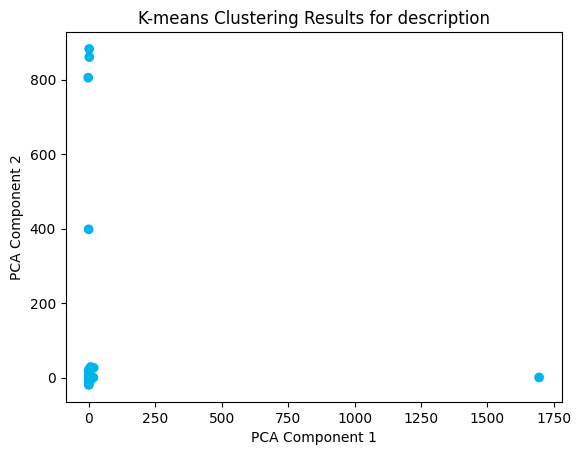


K-means clustering for column: requirements
                                        requirements  requirements_cluster
0  Experience with content management systems a m...                     0
1  What we expect from you:Your key responsibilit...                     0
2  Implement pre-commissioning and commissioning ...                     0
3  EDUCATION: Bachelor’s or Master’s in GIS, busi...                     0
4  QUALIFICATIONS:RN license in the State of Texa...                     0


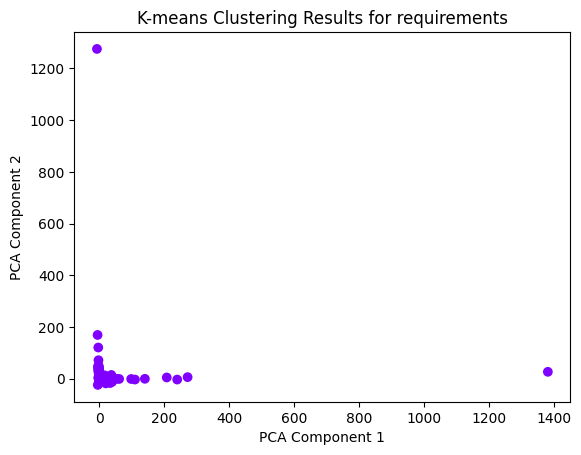


K-means clustering for column: benefits
                                            benefits  benefits_cluster
0                                       Not Provided                 3
1  What you will get from usThrough being part of...                 3
2                                       Not Provided                 3
3  Our culture is anything but corporate—we have ...                 3
4                              Full Benefits Offered                 3


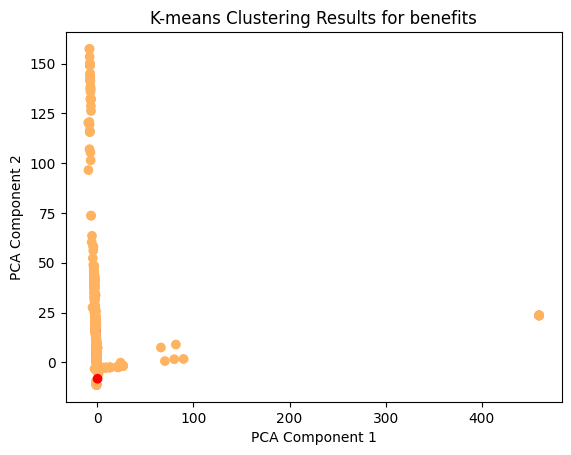


K-means clustering for column: title
                                       title  title_cluster
0                           Marketing Intern              1
1  Customer Service - Cloud Video Production              1
2    Commissioning Machinery Assistant (CMA)              1
3          Account Executive - Washington DC              1
4                        Bill Review Manager              1


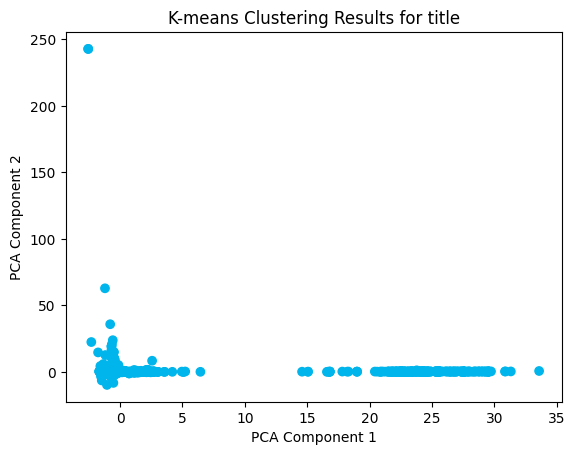


K-means clustering for column: company_profile
                                     company_profile  company_profile_cluster
0  We're Food52, and we've created a groundbreaki...                        0
1  90 Seconds, the worlds Cloud Video Production ...                        0
2  Valor Services provides Workforce Solutions th...                        0
3  Our passion for improving quality of life thro...                        0
4  SpotSource Solutions LLC is a Global Human Cap...                        0


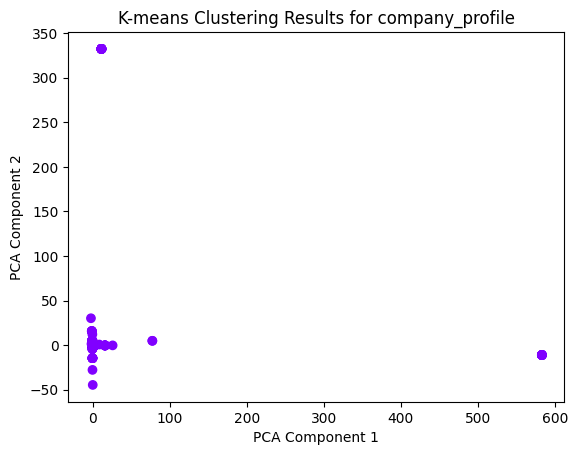

In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Dictionary to store K-means models and labels for each column
kmeans_models = {}
cluster_labels = {}

# Perform K-means clustering for each BoW matrix separately
for col in columns:
    print(f"\nK-means clustering for column: {col}")
    
    # Standardize the feature matrix
    scaler = StandardScaler(with_mean=False)
    scaled_features = scaler.fit_transform(bow_matrices[col])

    # Define the K-means model
    kmeans = KMeans(n_clusters=5, random_state=42)
    
    # Fit the model to the scaled features
    kmeans.fit(scaled_features)
    
    # Store the model and cluster labels
    kmeans_models[col] = kmeans
    cluster_labels[col] = kmeans.labels_
    
    # Add the cluster labels to your DataFrame
    df_cleaned[f'{col}_cluster'] = kmeans.labels_

    # Print sample cluster assignments
    print(df_cleaned[[col, f'{col}_cluster']].head())
    
    # Visualize clustering results with PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features.toarray())  # Convert to dense for PCA

    plt.figure()
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans.labels_, cmap='rainbow')
    plt.title(f'K-means Clustering Results for {col}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()


In [24]:
#Intrepret the graphs

# Get the top words in each cluster
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(5):  # Assuming 5 clusters
    print(f"Cluster {i} top words:")
    top_words = [terms[ind] for ind in order_centroids[i, :10]]  # Top 10 words
    print(top_words)


Cluster 0 top words:
['and', 'to', 'the', 'in', 'is', 'of', 'for', 'we', 'our', 'with']
Cluster 1 top words:
['companywide', 'lei', 'craftsman', 'columbus', 'phases', 'craftsmanship', 'likewise', 'indianapolis', 'enhancements', 'tri']
Cluster 2 top words:
['pingdom', 'årets', 'servrar', 'industri', 'tillgänglighet', 'ägare', 'är', 'pingdoms', 'även', 'länder']
Cluster 3 top words:
['url_79acfcc7a99f008faaebd34c27f49d6df500e067c8eddd709a488e4201a00774', 'ανήκει', 'λειτουργικότητες', 'εταιρείας', 'ελληνικό', 'κύπρο', 'κάτι', 'ευρώπη', 'συμμετέχει', 'παρέχει']
Cluster 4 top words:
['marks', 'aspex', 'clientswe', 'marketplacecandidatesinclude', 'relating', 'specifications', 'recruitmentwe', 'standby', 'hunting', 'resourcing']


In [32]:
import pandas as pd

# Initialize a writer for a multi-sheet Excel file
with pd.ExcelWriter("C:/Users/Aftershock/Desktop/BT4012/Group Project/BT4012fake_job_posting/dataset/clusters_per_column.xlsx") as writer:
    # Loop through each column to save clustering info
    for col in columns:
        # Create a DataFrame with the text data and corresponding cluster label for the column
        cluster_df = df_cleaned[[col, f'{col}_cluster']]
        
        # Rename columns for clarity in the Excel file
        cluster_df.columns = [f'{col}_text', 'cluster']
        
        # Sort by cluster to group all entries by cluster number
        cluster_df = cluster_df.sort_values(by='cluster')
        
        # Write the DataFrame to a new sheet named after the column
        cluster_df.to_excel(writer, sheet_name=f'{col}_clusters', index=False)

print("Clusters saved to clusters_per_column.xlsx")


OSError: Cannot save file into a non-existent directory: 'Group Project\BT4012fake_job_posting\dataset'

In [ ]:
print(cluster_0)

From the data we can see that the first cluster, cluster 0 has a 100% fraudulent rate which indicates that the cluster may provide significant insight into identifying fraudulent job postings
